# Lyft: Complete train and prediction pipeline (update for l5kit 1.1.0)


# Environment setup

In [1]:
# !pip -q install l5kit==1.1.0

In [2]:
# !pip -q install timm

In [1]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50, resnet18, resnet34, resnet101
from tqdm import tqdm

import l5kit
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import matplotlib.pyplot as plt

import os
import random
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
import timm

In [3]:
l5kit.__version__

'1.1.0'

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(42)

## Configs

In [6]:
# --- Lyft configs ---
cfg = {
    'format_version': 4,
    'data_path': "lyft_dataset",
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'model_name': "model_resnet34_output",
        "LSTM_hidden_size": 64,
        "alpha": 0.1,
        "num_trajectories":3,
        'lr': 1e-3,
        'train': False,
        'predict': True
    },

    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },

    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 2
    },
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 16,
        'shuffle': False,
        'num_workers': 2
    },
    'train_params': {
        'max_num_steps': 101,
        'checkpoint_every_n_steps': 20,
    }
}

## Load the train and test data

In [7]:
# set env variable for data
DIR_INPUT = cfg["data_path"]
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)

In [8]:
# ===== INIT TRAIN DATASET============================================================
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()

#create mask 


train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print("==================================TRAIN DATA==================================")
print(train_dataset)

==================================TRAIN DATA==================================
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [9]:
# ===== INIT EGO TRAIN DATASET============================================================
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()

#create mask 
train_dataset_ego = EgoDataset(cfg, train_zarr, rasterizer)
train_dataloader_ego = DataLoader(train_dataset_ego, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print("==================================EGO TRAIN DATA==================================")
print(train_dataset_ego)

==================================EGO TRAIN DATA==================================
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [10]:
# #====== INIT TEST DATASET=============================================================
# test_cfg = cfg["test_data_loader"]
# rasterizer = build_rasterizer(cfg, dm)
# test_zarr = ChunkedDataset(dm.require(test_cfg["key"])).open()
# test_mask = np.load(f"{DIR_INPUT}/scenes/mask.npz")["arr_0"]
# test_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)
# test_dataloader = DataLoader(test_dataset,shuffle=test_cfg["shuffle"],batch_size=test_cfg["batch_size"],
#                              num_workers=test_cfg["num_workers"])
# print("==================================TEST DATA==================================")
# print(test_dataset)

## Testing Dataloader

## Simple visualization

Let us visualize how an input to the model looks like.

In [11]:
def visualize_trajectory(dataset, index, title="target_positions movement with draw_trajectory"):
    data, indice = dataset[index]
    im = data["image"].transpose(1, 2, 0)
    print(im.shape)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, radius=1, yaws=data["target_yaws"])

    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()

(224, 224, 25)


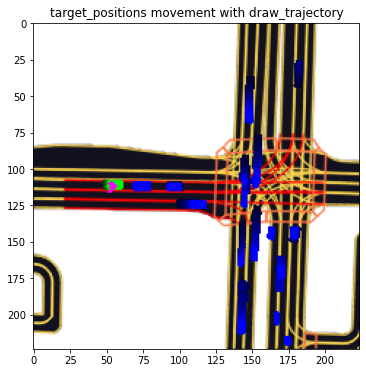

In [12]:
plt.figure(figsize = (8,6))
visualize_trajectory(train_dataset, index=90)

## Loss function

For this competition it is important to use the correct loss function when train the model. Our goal is to predict three possible paths together with the confidence score, so we need to use the loss function that takes that into account, simply using RMSE will not lead to an accurate model. More information about the loss function can be found here [negative log likelihood](https://github.com/lyft/l5kit/blob/master/competition.md).

In [13]:
# --- Function utils ---
# Original code from https://github.com/lyft/l5kit/blob/20ab033c01610d711c3d36e1963ecec86e8b85b6/l5kit/l5kit/evaluation/metrics.py
import numpy as np

import torch
from torch import Tensor


def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    print(batch_size)
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


def pytorch_neg_multi_log_likelihood_single(
    gt: Tensor, pred: Tensor, avails: Tensor
) -> Tensor:
    """

    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(time)x(2D coords)
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    # pred (bs)x(time)x(2D coords) --> (bs)x(mode=1)x(time)x(2D coords)
    # create confidence (bs)x(mode=1)
    batch_size, future_len, num_coords = pred.shape
    confidences = pred.new_ones((batch_size, 1))
    return pytorch_neg_multi_log_likelihood_batch(gt, pred.unsqueeze(1), confidences, avails)

## Roshan's Model

In [14]:
class SimpleNet(nn.Module):
    def __init__(self, cfg):
        super(SimpleNet, self).__init__()
        num_targets = 2 * cfg["model_params"]["future_num_frames"]
        self.net = nn.Sequential(nn.Conv2d(25, 5, kernel_size = 3, padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(5, 2, kernel_size = 3, padding=1),
                                 nn.Flatten(),
                                 nn.Linear(224*224*2, num_targets)
                                 )
    def forward(self, x):
        x = self.net(x)
        return x

In [15]:
class ConvNet1(nn.Module):
    def __init__(self, cfg, backbone):
        super().__init__()
        
        num_targets = 2 * cfg["model_params"]["future_num_frames"]*cfg["model_params"]["num_trajectories"]
        self.backbone = timm.create_model(backbone, pretrained=True, in_chans=25)
        if backbone == "xception41":
            num_out_backbone = 1000
        self.fc1 = nn.Linear(num_out_backbone, num_targets)
        self.confidences = nn.Linear(num_targets, 3)
        self.predictions_shape = (cfg["model_params"]["num_trajectories"], cfg["model_params"]["future_num_frames"], 2)
    def forward(self, x):
        x = self.backbone(x)
        x = F.relu(x)
        predictions = self.fc1(x)
        confidences = F.softmax(self.confidences(predictions))
        predictions_out = predictions.view(-1, self.predictions_shape[0], self.predictions_shape[1], self.predictions_shape[2])
#         if not torch.allclose(torch.sum(confidences, dim=1),torch.ones((16)).to("cuda")):
#             breakpoint()
        return predictions_out, confidences

In [16]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs, confidences = model(inputs)
#     loss = criterion(outputs, targets)
    loss = criterion(targets, outputs, confidences, target_availabilities.squeeze())
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
#     loss = loss * target_availabilities
#     loss = loss.mean()
    return loss, outputs, confidences

In [17]:
def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences + 1e-10) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)

In [33]:
from typing import List, Optional, Tuple

def get_agent_context(
        state_index: int,
        frames: np.ndarray,
        agents: np.ndarray,
#         tl_faces: np.ndarray,
        history_num_frames: int,
        future_num_frames: int,
) -> Tuple[np.ndarray, np.ndarray, List[np.ndarray], List[np.ndarray]]:
    """
    Slice zarr or numpy arrays to get the context around the agent onf interest (both in space and time)
    Args:
        state_index (int): frame index inside the scene
        frames (np.ndarray): frames from the scene
        agents (np.ndarray): agents from the scene
        tl_faces (np.ndarray): tl_faces from the scene
        history_num_frames (int): how many frames in the past to slice
        future_num_frames (int): how many frames in the future to slice
    Returns:
        Tuple[np.ndarray, np.ndarray, List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray]]
    """

    #  the history slice is ordered starting from the latest frame and goes backward in time., ex. slice(100, 91, -2)
    history_slice = l5kit.sampling.slicing.get_history_slice(state_index, history_num_frames, 1, include_current_state=True)
    future_slice = l5kit.sampling.slicing.get_future_slice(state_index, future_num_frames, 1)
    history_frames = frames[history_slice].copy()  # copy() required if the object is a np.ndarray
    future_frames = frames[future_slice].copy()
    sorted_frames = np.concatenate((history_frames[::-1], future_frames))  # from past to future

    # get agents (past and future)
    agent_slice = l5kit.data.filter.get_agents_slice_from_frames(sorted_frames[0], sorted_frames[-1])
    agents = agents[agent_slice].copy()
    # sync interval with the agents array
    history_frames["agent_index_interval"] -= agent_slice.start
    future_frames["agent_index_interval"] -= agent_slice.start
    history_agents = l5kit.data.filter.filter_agents_by_frames(history_frames, agents)
    future_agents = l5kit.data.filter.filter_agents_by_frames(future_frames, agents)
#     print("agents {}".format(agent_slice))

#     # get traffic lights (past and future)
#     tl_slice = get_tl_faces_slice_from_frames(sorted_frames[0], sorted_frames[-1])
#     tl_faces = tl_faces[tl_slice].copy()
#     # sync interval with the traffic light faces array
#     history_frames["traffic_light_faces_index_interval"] -= tl_slice.start
#     future_frames["traffic_light_faces_index_interval"] -= tl_slice.start
#     history_tl_faces = filter_tl_faces_by_frames(history_frames, tl_faces)
#     future_tl_faces = filter_tl_faces_by_frames(future_frames, tl_faces)
    return history_frames, future_frames, history_agents, future_agents #, history_tl_faces, future_tl_faces


In [18]:
import bisect

def get_agent_data(index, ego_dataset, agent_dataset):
    if index < 0:
        if -index > len(agent_dataset):
            raise ValueError("absolute value of index should not exceed dataset length")
        index = len(agent_dataset) + index
        index = agent_dataset.agents_indices[index]

    frame_index = bisect.bisect_right(agent_dataset.cumulative_sizes_agents, index)
    scene_index = bisect.bisect_right(agent_dataset.cumulative_sizes, frame_index)
    if scene_index == 0:
        state_index = frame_index
    else:
        state_index = frame_index - agent_dataset.cumulative_sizes[scene_index - 1]
    frames = ego_dataset.dataset.frames[l5kit.data.filter.get_frames_slice_from_scenes(ego_dataset.dataset.scenes[scene_index])]

    agents = ego_dataset.dataset.agents
    x = get_agent_context(state_index, frames, agents, history_num_frames= 10, future_num_frames = 50)
    return x[2]

In [19]:
class CSP(nn.Module):
    def __init__(self, cfg, device):
        super().__init__()
        self.CSPEncoder = CSPEncoder(cfg).to(device)
        self.SocialPooling = SocialPooling(cfg, device).to(device)
        self.CSPDecoder = CSPDecoder(cfg).to(device)

    def forward(self,nbrs_hist, ego_hist, masks):
        nbrs_encoded, ego_encoded = self.CSPEncoder(nbrs_hist, ego_hist)
        trajectory_concated = self.SocialPooling(nbrs_encoded, ego_encoded, masks)
        predictions, confidences = self.CSPDecoder(trajectory_concated)
        return predictions, confidences

In [20]:
class CSPEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        #need linear layer??
        self.num_history = cfg["model_params"]["history_num_frames"]
        self.alpha = cfg["model_params"]["alpha"]
        self.LSTM_hidden_size = cfg["model_params"]["LSTM_hidden_size"]
        self.encoderLSTM = nn.LSTM(2, self.LSTM_hidden_size,1)
  
    def forward(self,nbrs_hist, ego_hist):
        #nbrs_hist: BxNxHx2 --> (BxN)xHx2
        nbrs_hist_encoded =  nbrs_hist.view(nbrs_hist.shape[0]*nbrs_hist.shape[1],nbrs_hist.shape[2], nbrs_hist.shape[3])
        _, (neighbors_encoded, _) = self.encoderLSTM(nbrs_hist_encoded.permute(1,0,2).float())
        neighbors_encoded = neighbors_encoded.view(nbrs_hist.shape[0], nbrs_hist.shape[1], self.LSTM_hidden_size)
        neighbors_encoded = neighbors_encoded.squeeze(0)
        neighbors_encoded = F.leaky_relu(neighbors_encoded, self.alpha)
        _, (ego_encoded, _) = self.encoderLSTM(ego_hist.permute(1,0,2))
        ego_encoded = ego_encoded.squeeze(0)
        ego_encoded = F.leaky_relu(ego_encoded, self.alpha)
        return neighbors_encoded, ego_encoded

In [21]:
class SocialPooling(nn.Module):
    def __init__(self, cfg, device):
        super().__init__()
        self.encoder_LSTM_hidden_state_shape = cfg["model_params"]["LSTM_hidden_size"]

        self.conv1 = nn.Conv2d(self.encoder_LSTM_hidden_state_shape, 64, kernel_size = 3)
        self.conv2 = nn.Conv2d(64, 16, kernel_size = (3,1))
        self.max_pool = nn.MaxPool2d(kernel_size = (2,1))
        self.social_reduction = nn.Linear(704, 32)
        self.vehicle_dynamics = nn.Linear(self.encoder_LSTM_hidden_state_shape, 32)
        self.alpha = cfg["model_params"]["alpha"]
        self.device = device
  
    def forward(self, nbrs_encoding, ego_encoding, masks):
        social_encoding = torch.zeros((masks.shape[0],masks.shape[1],masks.shape[2], self.encoder_LSTM_hidden_state_shape)).to(self.device)
        nbrs_curr_stacked = torch.repeat_interleave(masks.byte().unsqueeze(3), self.encoder_LSTM_hidden_state_shape, dim = 3)
        
        social_encoding = social_encoding.masked_scatter_(nbrs_curr_stacked, nbrs_encoding)
        nbrs_conved = self.conv1(social_encoding.permute(0,3,1,2))
        nbrs_conved = F.leaky_relu(nbrs_conved, self.alpha)
        nbrs_conved = self.conv2(nbrs_conved)
        nbrs_conved = F.leaky_relu(nbrs_conved, self.alpha)
        nbrs_conved = self.max_pool(nbrs_conved)
        nbrs_conved = torch.flatten(nbrs_conved, start_dim = 1, end_dim = 3)
        nbrs_conved = self.social_reduction(nbrs_conved)
        x_ego = self.vehicle_dynamics(ego_encoding)

        traj_concat = torch.cat((nbrs_conved, x_ego), dim = 1)
        return traj_concat

In [22]:
class CSPDecoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.decoderLSTM = nn.LSTM(1, 30, 1, batch_first = True)
        num_outputs = 30
        self.output_predictions = nn.Linear(30, 2*cfg["model_params"]["future_num_frames"]*cfg["model_params"]["num_trajectories"]) #50 50x2x3
        self.confidences = nn.Linear(30, cfg["model_params"]["num_trajectories"]) #50 50x2x3
        self.alpha = cfg["model_params"]["alpha"]
        self.predictions_shape = (cfg["model_params"]["num_trajectories"], cfg["model_params"]["future_num_frames"],2)
    def forward(self, trajectory_concated):
        trajectory_concated = trajectory_concated.unsqueeze(2)
        _, (hidden, _) = self.decoderLSTM(trajectory_concated)
        hidden = F.leaky_relu(hidden.permute(1,0,2), self.alpha)
        
        predictions = self.output_predictions(hidden).squeeze(1).view(-1, self.predictions_shape[0], self.predictions_shape[1], self.predictions_shape[2])

        confidences = F.softmax(self.confidences(hidden).squeeze(1))
        return predictions, confidences 

In [23]:
#adds in complexnet output...
class CSPDecoder2(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
        self.ComplexNet = torch.load("models/ComplexNet1v1.pt")
        self.ComplexNet.eval()
        #might need to retrain complexNet with the current configs?
        self.decoderLSTM = nn.LSTM(1, 30, 1, batch_first = True)
        num_outputs = 30
        output_flat_shape = 2*cfg["model_params"]["future_num_frames"]*cfg["model_params"]["num_trajectories"]
        self.output_predictions = nn.Linear(30, output_flat_shape) #50 50x2x3
        
        self.convScaling = nn.Linear(2*cfg["model_params"]["future_num_frames"], output_flat_shape)
        self.CSP_Scaling = nn.Linear(output_flat_shape, output_flat_shape)
        
        self.confidences = nn.Linear(output_flat_shape, cfg["model_params"]["num_trajectories"]) #50 50x2x3
        self.alpha = cfg["model_params"]["alpha"]
        self.predictions_shape = (cfg["model_params"]["num_trajectories"], cfg["model_params"]["future_num_frames"],2)
        
    def forward(self, trajectory_concated, ims):
        trajectory_concated = trajectory_concated.unsqueeze(2)
        _, (hidden, _) = self.decoderLSTM(trajectory_concated)
        hidden = F.leaky_relu(hidden.permute(1,0,2), self.alpha)
        complexNet_predictions = self.ComplexNet(ims)
        
        csp_predictions = self.output_predictions(hidden).squeeze(1).view(-1, self.predictions_shape[0], self.predictions_shape[1], self.predictions_shape[2])
        predictions = self.convScaling(complexNet_predictions)+self.CSP_scaling(csp_predictions)
        confidences = F.softmax(self.confidences(predictions).squeeze(1))
        return predictions, confidences 

In [24]:
def generate_mask_coords(agent_centroid, ego_centroid, mask):
    """agent_centroid: (,2) arr
       ego_centroid: (,2 arr)"""
    assert len(agent_centroid.shape) == 1
    assert mask.shape[1]%2 == 1 #masks must be odd number shaped
    assert mask.shape[2]%2 == 1 #masks must be odd number shaped
    
    rel_centroid = agent_centroid-ego_centroid
    #for now, let's generate a 13x13 mask. Could choose long mask (e.x. 13x3) if we
    #input ego heading to determine whether x or y becomes the long end.
    
    #1 square == ~15 feet
    map_x_uncentered = rel_centroid[0]//15
    map_y_uncentered = rel_centroid[1]//15
    
    #Adjust coords to put ego vehicle in center, and flip x and y for python array indexing
    map_x_center = mask.shape[1]//2+1
    map_y_center = mask.shape[2]//2+1
    
    map_x_centered = map_y_center-map_y_uncentered
    map_y_centered = map_x_center+map_x_uncentered

    if map_x_centered < 0 or map_x_centered >= mask.shape[1]:
        return None
    if map_y_centered < 0 or map_y_centered >= mask.shape[2]:
        return None
    else:
        return [int(map_x_centered), int(map_y_centered)]

In [25]:
def CSPforward(data,index, model, ego_dataset, agent_dataset, criterion=pytorch_neg_multi_log_likelihood_batch, device = "cuda"):
#     nbrs_batch = torch.zeros(len(indices),0,0,2) #Want BxNxHx2
    masks = torch.zeros((len(indices), 13, 13))
    tot_nbrs = []
    for i, scene_id in enumerate(indices):
        nbrs = torch.zeros(0,10,2)
        agent_data = get_agent_data(scene_id, ego_dataset, agent_dataset)
        cur_agents = agent_data[0]
        filtered_agents = l5kit.data.filter.filter_agents_by_labels(cur_agents, 0.5)
        curr_valid_agents = filtered_agents["track_id"]
        for agent_id in curr_valid_agents:
            agent_history = []
            for frame in agent_data:
                agent_id_index = np.where(frame["track_id"] == agent_id)
                if len(agent_id_index[0]) > 0:
                    agent_history.append(frame["centroid"][agent_id_index])
                else:
                    #Agent was not seen for this frame...
                    agent_history.append(np.array([[0,0]]))
                agent_history_arr = np.array(agent_history)[:-1].squeeze(1)
            agent_history_arr=np.flip(agent_history_arr, axis=0).copy()
            agent_curr_coords = agent_history_arr[-1]
            agent_mask_coords = generate_mask_coords(agent_curr_coords, data["centroid"][i].numpy(), masks)
            
            if agent_mask_coords is not None:
                masks[i, agent_mask_coords[0], agent_mask_coords[1]] = 1
            new_hist = torch.from_numpy(agent_history_arr).unsqueeze(0)
            nbrs = torch.cat((nbrs, new_hist), axis = 0)
        tot_nbrs.append(nbrs)
    
    nbrs_batch = torch.nn.utils.rnn.pad_sequence(tuple(tot_nbrs), batch_first=True)
#     nbrs_batch_packed = torch.nn.utils.rnn.pack_sequence(tuple(tot_nbrs),enforce_sorted=False)
    ego_hist = data["history_positions"][:,:-1]
    ego_hist = ego_hist[torch.arange(ego_hist.shape[0]).unsqueeze(-1), data["history_availabilities"][:,:-1].long()]
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    nbrs_current_mask = data["image"][:,cfg["model_params"]["history_num_frames"]+1,:,:]

    predictions, confidences = model(nbrs_batch.to(device), ego_hist.to(device), masks.to(device))
    loss = criterion(targets, predictions, confidences, target_availabilities)
    return loss, predictions, confidences

In [26]:
# # ==== INIT MODEL
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = torch.load("models/CSPv1_epoch9.pt")

In [27]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# model = CSP(cfg, device).to(device)
model = ConvNet1(cfg, backbone="xception41").to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = pytorch_neg_multi_log_likelihood_batch
epochs = 2
# criterion = nn.MSELoss(reduction="none")

In [28]:
##TODO:


#Hyperparam tuning
    #1. Leanring rate
    #2. Gradient clipping
    #3. Learning rate scheduling
    #4. Adjusting momentum in Adam optimizer

#Further ideas:
    #1. Combine output of *trained* ConvNetv1 with CSP (to allow net to get understanding of road geometry)
    #2. Make confidences a funciton of predictions by passing predictions through self.confidences(), not hidden.

In [29]:
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
losses_train = []
for i in range(epochs):
    print("Epoch {}".format(i))
    progress_bar = tqdm(range(400))
    for _ in progress_bar:
        try:
            data, indices = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            data, indices = next(tr_it)
        model.train()
        torch.set_grad_enabled(True)
#         loss, predictions, confidences = CSPforward(data, indices, model, train_dataset_ego, train_dataset, criterion, device = device)
        loss, predictions, confidences = forward(data, model, device, criterion)
        # batch_size, num_modes, future_len, num_coords = pred.shape
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.item())
        progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
    torch.save(model, "models/ConvNetV2_epoch{}.pt".format(i))

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0


loss: 365.9700927734375 loss(avg): 727.2663187551499: 100%|██████████| 400/400 [04:58<00:00,  1.34it/s]  
  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1


loss: 395.9671936035156 loss(avg): 537.9042512071132: 100%|██████████| 400/400 [04:56<00:00,  1.35it/s] 


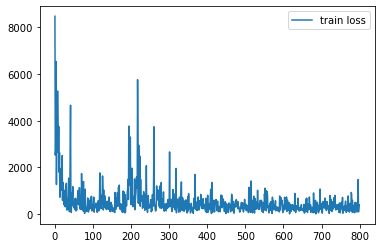

In [30]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

In [31]:
# #If CUDA out of memory:
# torch.cuda.empty_cache()

In [33]:
torch.save(model, "models/ComplexNet1v2.pt")

## Roshan's Model Eval

In [34]:
# ===== GENERATE AND LOAD CHOPPED DATASET
import shutil
eval_cfg = cfg["test_data_loader"]
!rm -rf /tmp/lyft
eval_dir = shutil.copytree(dm.require(eval_cfg["key"]), '/tmp/lyft/test.zarr')

In [35]:
eval_cfg = cfg["test_data_loader"]


In [ ]:
num_frames_to_chop = 50
eval_base_path = create_chopped_dataset(eval_dir, cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)
!ls {eval_base_path}

starting pool...


1614/11314: : 1612it [01:23, 26.92it/s]

In [ ]:
eval_zarr_path = str(Path(eval_base_path) / "test.zarr")
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

In [ ]:
eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])

In [ ]:
eval_dataset_ego = EgoDataset(cfg, eval_zarr, rasterizer)

In [ ]:
# ===== EVAL Loop
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
confidences_list = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)

for data, indices in progress_bar:

#     loss, preds, confidences = CSPforward(data, indices, model, eval_dataset_ego, eval_dataset, criterion, device = device)
    loss, preds, confidences = forward(data, model, device, criterion)
    #fix for the new environment
    preds = preds.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = []

    # convert into world coordinates and compute offsets
    for idx in range(len(preds)):
        for mode in range(cfg["model_params"]["num_trajectories"]):
            preds[idx,mode,:, :] = transform_points(preds[idx,mode,:, :], world_from_agents[idx]) - centroids[idx][:2]

    future_coords_offsets_pd.append(preds.copy())
    confidences_list.append(confidences.cpu().numpy().copy())
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy()) 

In [ ]:
pred_path = f"{gettempdir()}/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
               confs = np.concatenate(confidences_list)
              )

In [ ]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)

## Model

Next we define the baseline model. Note that this model will return three possible trajectories together with confidence score for each trajectory.

In [19]:
class LyftMultiModel(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        architecture = cfg["model_params"]["model_architecture"]
        backbone = eval(architecture)(pretrained=True, progress=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )

        # This is 512 for resnet18 and resnet34;
        # And it is 2048 for the other resnets
        
        if architecture == "resnet50":
            backbone_out_features = 2048
        else:
            backbone_out_features = 512

        # X, Y coords for the future positions (output shape: batch_sizex50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        # You can add more layers here.
        self.head = nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(in_features=backbone_out_features, out_features=4096),
        )

        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.logit = nn.Linear(4096, out_features=self.num_preds + num_modes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.head(x)
        x = self.logit(x)

        # pred (batch_size)x(modes)x(time)x(2D coords)
        # confidences (batch_size)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

In [20]:
def forward(data, model, device, criterion = pytorch_neg_multi_log_likelihood_batch):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    preds, confidences = model(inputs)
    loss = criterion(targets, preds, confidences, target_availabilities)
    return loss, preds, confidences

Now let us initialize the model and load the pretrained weights. Note that since the pretrained model was trained on GPU, you also need to enable GPU when running this notebook.

In [21]:
# ==== INIT MODEL=================
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LyftMultiModel(cfg)

#load weight if there is a pretrained model
weight_path = cfg["model_params"]["weight_path"]
if weight_path:
    model.load_state_dict(torch.load(weight_path))

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg["model_params"]["lr"])
print(f'device {device}')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

KeyError: 'weight_path'

In [ ]:
print(model)

## Training loop

Next let us implement the training loop, when the **train** parameter is set to True.

In [ ]:
# ==== TRAINING LOOP =========================================================
if cfg["model_params"]["train"]:
    
    tr_it = iter(train_dataloader)
    progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
    num_iter = cfg["train_params"]["max_num_steps"]
    losses_train = []
    iterations = []
    metrics = []
    times = []
    model_name = cfg["model_params"]["model_name"]
    start = time.time()
    for i in progress_bar:
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            data = next(tr_it)
        model.train()
        torch.set_grad_enabled(True)
        
        loss, _, _ = forward(data, model, device)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.item())

        progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
        if i % cfg['train_params']['checkpoint_every_n_steps'] == 0:
            torch.save(model.state_dict(), f'{model_name}_{i}.pth')
            iterations.append(i)
            metrics.append(np.mean(losses_train))
            times.append((time.time()-start)/60)

    results = pd.DataFrame({'iterations': iterations, 'metrics (avg)': metrics, 'elapsed_time (mins)': times})
    results.to_csv(f"train_metrics_{model_name}_{num_iter}.csv", index = False)
    print(f"Total training time is {(time.time()-start)/60} mins")
    print(results.head())

## Prediction

Finally we implement the inference to submit to Kaggle when **predict** param is set to True.

In [ ]:
# ==== EVAL LOOP ================================================================
if cfg["model_params"]["predict"]:
    
    model.eval()
    torch.set_grad_enabled(False)

    # store information for evaluation
    future_coords_offsets_pd = []
    timestamps = []
    confidences_list = []
    agent_ids = []

    progress_bar = tqdm(test_dataloader)
    
    for data in progress_bar:
        
        _, preds, confidences = forward(data, model, device)
    
        #fix for the new environment
        preds = preds.cpu().numpy()
        world_from_agents = data["world_from_agent"].numpy()
        centroids = data["centroid"].numpy()
        coords_offset = []
        
        # convert into world coordinates and compute offsets
        for idx in range(len(preds)):
            for mode in range(3):
                preds[idx, mode, :, :] = transform_points(preds[idx, mode, :, :], world_from_agents[idx]) - centroids[idx][:2]
    
        future_coords_offsets_pd.append(preds.copy())
        confidences_list.append(confidences.cpu().numpy().copy())
        timestamps.append(data["timestamp"].numpy().copy())
        agent_ids.append(data["track_id"].numpy().copy())

In [ ]:
#create submission to submit to Kaggle
pred_path = 'submission.csv'
write_pred_csv(pred_path,
           timestamps=np.concatenate(timestamps),
           track_ids=np.concatenate(agent_ids),
           coords=np.concatenate(future_coords_offsets_pd),
           confs = np.concatenate(confidences_list)
          )